This Jupyter Notebook contains implementations of Contiguous Frame Masking (CFM) and Contiguous Channel Masking (CCM), as described in the [Musicoder Paper](https://arxiv.org/abs/2008.00781).

#### Create sample input

In [142]:
import numpy as np

NUM_FRAMES = 128 # number of frames in one training example
NUM_FEATURES = 40 # number of features in every frame

In [143]:
sample = np.random.rand(NUM_FRAMES, NUM_FEATURES)

In [144]:
print(sample.shape)
print(sample)

(128, 40)
[[0.2052194  0.3852863  0.53426001 ... 0.73394084 0.24503277 0.61281242]
 [0.38144891 0.03653081 0.48419633 ... 0.0318949  0.3343211  0.39369209]
 [0.68886211 0.1580817  0.13043735 ... 0.24240859 0.5208199  0.87336492]
 ...
 [0.1880642  0.86913072 0.80754137 ... 0.16502716 0.62534205 0.16156029]
 [0.49527308 0.18630097 0.87109171 ... 0.93785371 0.92434493 0.61618475]
 [0.35645689 0.98906339 0.83212327 ... 0.69137201 0.23650907 0.68682174]]


#### CFM
"To avoid the model
exploiting local smoothness of acoustic frames, rather than only mask one span
with fixed number of consecutive frames [24], we mask several spans of consecutive frames dynamically. Given a sequence of input frames X = (x1, x2, ..., xn),
we select a subset Y ⊂ X by iteratively sampling contiguous input frames (spans)
until the masking budget (e.g., 15% of X) has been spent. At each iteration, the
span length is first sampled from a geometric distribution l ∼ Geo(p). Then
the starting point of the masked span is randomly selected. We set p = 0.2,
l_min = 2 and l_max = 7. The corresponding mean length of span is around 3.87
frames (≈ 179.6ms). In each masked span, the frames are masked according to
the following policy: 1) replace all frames with zero in 70% of the case. Since
each dimension of input frames are normalized to have zero mean value, setting the masked value to zero is equivalent to setting it to the mean value. 2)
replace all frames with a random masking frame in 20% of the case. 3) keep
the original frames unchanged in the rest 10% of the case. Since MusiCoder
will only receive acoustic frames without masking during inference time, policy
3) allows the model to receive real inputs during pre-training, and resolves the
pretrain-fintune inconsistency problem [12]."

In [145]:
P = 0.2
LMIN = 2
LMAX = 6 # this value results in approximate mean frame span of 3.88 frames
BUDGET = 0.15 # portion of frames of X selected
ZERO_OUT_CHANCE = 0.7
REPLACE_CHANCE = 0.2
# remaining chance is "keep original frame" policy chance

In [146]:
def cfm(X):
    frames_altered = 0
    while frames_altered < BUDGET*NUM_FRAMES: # keep going until budget allocated
        # Sample span length
        l = np.random.geometric(P)
        l = LMIN if l < LMIN else LMAX if l > LMAX else l # clamp to min and max vals
        
        # Sample starting frame of span
        s = np.random.randint(NUM_FRAMES)
        l = (NUM_FRAMES - s) if s+l > NUM_FRAMES else l
        
        # Select which policy (of 3) to apply, and apply it
        rand = np.random.rand()
        if rand<ZERO_OUT_CHANCE:
            # zero out frames
            X[s:s+l] = np.zeros((l, NUM_FEATURES))
        elif rand<ZERO_OUT_CHANCE+REPLACE_CHANCE:
            # replace frames with random frames
            rand_start = np.random.randint(NUM_FRAMES-l)
            X[s:s+l] = X[rand_start:rand_start+l]
        frames_altered += l
    return X

In [147]:
import copy

orig = copy.deepcopy(sample)
processed = cfm(sample)

##### Plot result

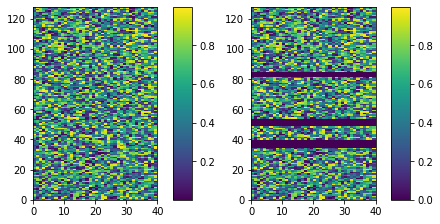

In [148]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis = cm.get_cmap('viridis', 256)

def plot_examples(cmap, data):
    fig, axs = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)
    for [ax, i] in zip(axs, data):
        psm = ax.pcolormesh(i, cmap=cmap)
        fig.colorbar(psm, ax=ax)
    plt.show()

plot_examples(viridis, [orig, processed])

#### CCM
The intuition of
channel masking is that a model available to predict the partial loss of channel information should have learned a high-level understanding along the channel axis. For log-mel spectrum and log-CQT features, a block of consecutive
channels is randomly masked to zero for all time steps across the input sequence of frames. Specifically, the number of masked blocks, n, is first sampled from {0, 1, . . . , H} uniformly. Then a starting channel index is sampled from
{0, 1, . . . , H − n}, where H is the number of total channels.

In [149]:
def ccm(X):
    # sample n
    n = np.random.randint(NUM_FEATURES)
    # NOTE: if features eventually becomes more than just mel bins, will need to alter this to sample mel-bins only
    
    # sample starting index
    s = np.random.randint(NUM_FEATURES-n)
    
    # mask to 0
    X[:, s:s+n] = np.zeros((NUM_FRAMES, n))
    
    return X

In [154]:
import copy

orig = copy.deepcopy(sample)
processed = ccm(sample)

##### Plot result

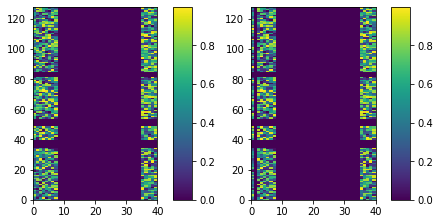

In [155]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis = cm.get_cmap('viridis', 256)

def plot_examples(cmap, data):
    fig, axs = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)
    for [ax, i] in zip(axs, data):
        psm = ax.pcolormesh(i, cmap=cmap)
        fig.colorbar(psm, ax=ax)
    plt.show()

plot_examples(viridis, [orig, processed])